In [1]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import warnings
import numpy as np
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
warnings.filterwarnings("ignore")
%matplotlib inline

# Loading Data

In [2]:
right_hand = pd.read_csv("/home/ubuntu/Desktop/project/HandRight.csv")
def addAlone(p):
    r = right_hand 
    r = r.iloc[:len(p)-1]
    r = r.reset_index(drop=True)
    r.drop('Time', inplace=True,axis=1)
    p.set_index(' Frame ID',inplace=True)
    p = p.reset_index(drop=True)
    f = pd.concat([p,r],axis=1)
    f = f.drop([' Hand Type',' # hands',' Frame ID'],axis=1)
    return f
def addOther(p):
    r = p[p[' Hand Type']=='right']
    r.drop('Time', inplace=True,axis=1)
    l = p[p[' Hand Type']=='left']
    r.set_index(' Frame ID',inplace=True)
    l.set_index(' Frame ID',inplace=True)
    f = pd.DataFrame(pd.merge(l,r, how='left',on=' Frame ID'))
    f = f.drop([' Hand Type_x',' # hands_y' ,' Hand Type_y' ,' # hands_x'],axis=1)
    return f
def addDf(p,name,exp):
    p = p.iloc[701:]
    if 'Alone' not in exp:
        f = addOther(p)
    else:
        f = addAlone(p) 
    f.columns = ['Time', ' Position X', ' Position Y', ' Position Z', ' Velocity X', ' Velocity Y',
       ' Velocity Z', ' Pitch', ' Roll', ' Yaw', ' Wrist Pos X',
       ' Wrist Pos Y', ' Wrist Pos Z', ' Elbow pos X', ' Elbow Pos Y',
       ' Elbow Pos Z', ' Grab Strenth', ' Grab Angle', ' Pinch Strength', ' Position X r',
       ' Position Y r', ' Position Z r', ' Velocity X r', ' Velocity Y r',
       ' Velocity Z r', ' Pitch r', ' Roll r', ' Yaw r', ' Wrist Pos X r',
       ' Wrist Pos Y r', ' Wrist Pos Z r', ' Elbow pos X r', ' Elbow Pos Y r',
       ' Elbow Pos Z r', ' Grab Strenth r', ' Grab Angle r', ' Pinch Strength r']
    f.insert(loc=0, column='Name', value=name)
    f.insert(loc=1, column='Type', value=exp)
    return f

In [3]:
def loadData(pathW):
    df = pd.DataFrame(columns=[
        'Name',
        'Type',
        'Time',
        ' Position X',
        ' Position Y',
        ' Position Z',
        ' Velocity X',
        ' Velocity Y',
        ' Velocity Z',
        ' Pitch',
        ' Roll',
        ' Yaw',
        ' Wrist Pos X',
        ' Wrist Pos Y',
        ' Wrist Pos Z',
        ' Elbow pos X',
        ' Elbow Pos Y',
        ' Elbow Pos Z',
        ' Grab Strenth',
        ' Grab Angle',
        ' Pinch Strength',
        ' Position X r',
        ' Position Y r',
        ' Position Z r',
        ' Velocity X r',
        ' Velocity Y r',
        ' Velocity Z r',
        ' Pitch r',
        ' Roll r',
        ' Yaw r',
        ' Wrist Pos X r',
        ' Wrist Pos Y r',
        ' Wrist Pos Z r',
        ' Elbow pos X r',
        ' Elbow Pos Y r',
        ' Elbow Pos Z r',
        ' Grab Strenth r',
        ' Grab Angle r',
        ' Pinch Strength r',
        ])
    path = pathW
    import os
    for folder in os.listdir(path):
        c_A = 0
        c_Sp = 0
        c_Sy = 0
        for fu in os.listdir(path + folder):
            if 'Alone' in fu:
                c_A += 1
            elif 'Sync' in fu:
                c_Sy += 1
            else:
                c_Sp += 1
        for fu in os.listdir(path + folder):
            if 'Alone' in fu and c_A != 1:
                c_A -= 1
                continue
            elif 'Sync' in fu and c_Sy != 1:
                c_Sy -= 1
                continue
            elif 'Spontan' in fu and c_Sp != 1:
                c_Sp -= 1
                continue
            x = pd.read_csv(path + folder + '/' + fu)
            df = pd.concat([df, addDf(x, ''.join(filter(str.isalpha,
                           fu[:8])), ''.join(filter(str.isalpha,
                           fu[8:len(fu) - 3])))], sort=False)
    return df

In [4]:
train = loadData("/home/ubuntu/Desktop/project/Training/")
test = loadData("/home/ubuntu/Desktop/project/Validation/")

In [5]:
train.dropna(inplace=True)
test.dropna(inplace=True)
train = train[train.index %20 == 0]
test = test[test.index %20 == 0]
train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)
x_train = train.copy().drop(['Name','Type','Time'], axis = 1)
y_train = train['Type']
x_test = test.copy().drop(['Name','Type','Time'], axis = 1)
y_test = test['Type']

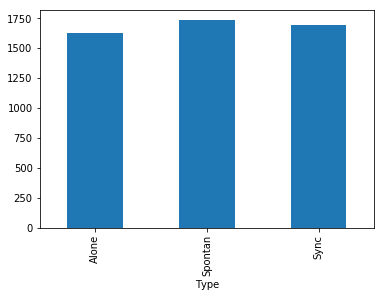

In [35]:
train.groupby('Type')['Time'].count().plot(kind='bar')

# Feature Exploration and Visualization

In [7]:
pca = PCA(n_components=25)
principalComponents = pca.fit_transform(x_train)
principalDf = pd.DataFrame(data = principalComponents)
principalDf.reset_index(drop=True, inplace=True)
final = pd.concat([principalDf, y_train.reset_index(drop=True)],axis=1)
final.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,Type
0,-211.288576,-148.644453,-69.298770,16.031697,-29.823269,27.794365,77.038238,38.542117,-166.509872,59.465119,...,-3.191918,-2.130401,4.355989,0.935320,-4.807743,-0.883809,3.539605,3.405627,-0.233899,Sync
1,-198.750827,-163.748841,-30.391206,0.285118,-31.451868,90.258143,28.710501,29.184681,-334.222634,104.786258,...,1.693622,4.377777,3.097460,1.527530,-5.157349,1.635778,3.300130,3.727220,-0.364576,Sync
2,31.216888,-128.189204,-26.852756,-33.252938,3.067336,145.940194,-16.243907,89.139467,-404.619459,112.706922,...,4.130495,5.719352,-0.076155,1.376820,-5.137128,-2.457131,3.305331,4.592859,-0.536336,Sync
3,255.857050,384.639589,-20.757047,-28.659953,-11.496047,111.680186,-61.789149,108.124175,-329.938271,95.246518,...,-4.474427,2.845609,2.353793,0.918217,-3.799063,-6.298352,4.038599,3.674324,-0.555594,Sync
4,208.308774,238.581028,-60.094169,-50.293135,-29.172073,41.019214,0.708271,82.316715,-139.948684,32.039933,...,-21.454643,0.333657,-1.912386,0.702977,-0.240031,-9.685098,3.757389,1.789032,-0.443284,Sync


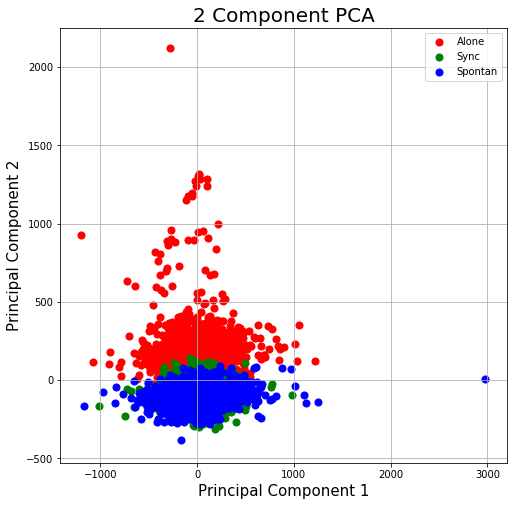

In [8]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)


targets = ['Alone', 'Sync', 'Spontan']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = final['Type'] == target
    ax.scatter(final.loc[indicesToKeep, 1]
               , final.loc[indicesToKeep, 2]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

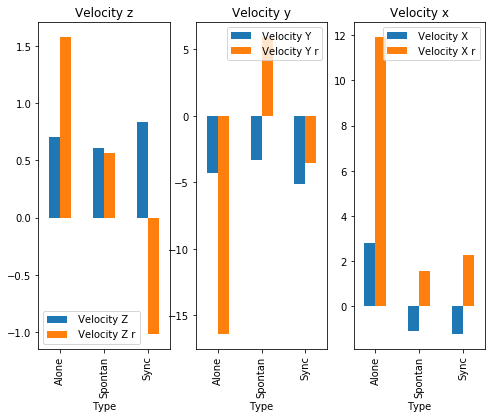

In [9]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1,3,1)
train.groupby(['Type'])[' Velocity Z', ' Velocity Z r'].mean().plot(kind='bar', title='Velocity z', ax=ax)
ax2 = fig.add_subplot(1,3,2)
train.groupby(['Type'])[' Velocity Y', ' Velocity Y r'].mean().plot(kind='bar', title= 'Velocity y',ax=ax2)
ax3 = fig.add_subplot(1,3,3)
train.groupby(['Type'])[' Velocity X', ' Velocity X r'].mean().plot(kind='bar', title= 'Velocity x',ax=ax3)

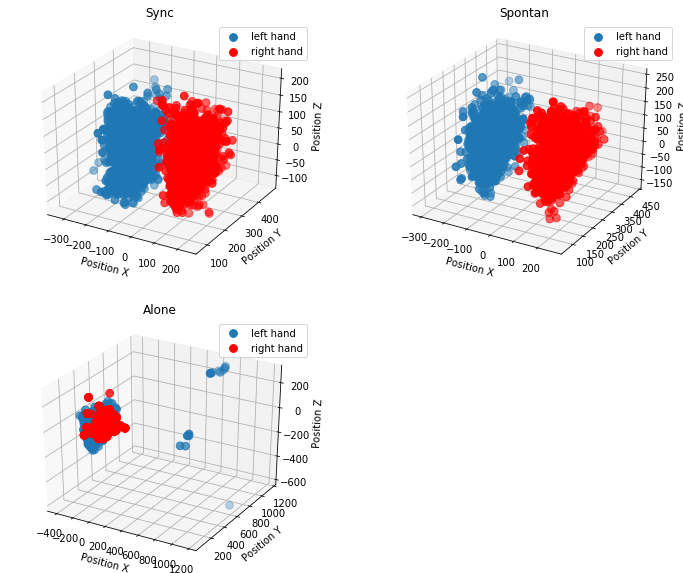

In [10]:
df = train.drop('Name',axis=1)
fig = plt.figure(figsize=(12, 10))
Type = ['Sync', 'Spontan','Alone']
count = 1
for t in Type:
    ax = fig.add_subplot(2, 2, count, projection='3d')
    count+=1
    ax.title.set_text(t)
    plt.gca().legend(('left','right'))
    dfS = df[df.Type == t]
    ax.scatter(dfS[' Position X'], dfS[' Position Y'], dfS[' Position Z'],s=60, label='left hand')
    ax.scatter(dfS[' Position X r'], dfS[' Position Y r'], dfS[' Position Z r' ], color='red',s=60, label='right hand')
    plt.legend()
    ax.set_xlabel('Position X')
    ax.set_ylabel('Position Y')
    ax.set_zlabel('Position Z')

# Modles and feature selection

## Null Classifer

In [11]:
from sklearn.dummy import DummyClassifier
dummy_classifier = DummyClassifier(strategy="uniform")
dummy_classifier.fit(x_train, y_train)
print(dummy_classifier.score(x_test,y_test))
y_pred = dummy_classifier.predict(x_test)
print(classification_report(y_test, y_pred))

0.3232118758434548
              precision    recall  f1-score   support

       Alone       0.30      0.31      0.30       474
     Spontan       0.33      0.34      0.34       506
        Sync       0.32      0.30      0.31       502

   micro avg       0.32      0.32      0.32      1482
   macro avg       0.32      0.32      0.32      1482
weighted avg       0.32      0.32      0.32      1482



In [12]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train, y_train)
print(knn.score(x_test,y_test))
print(f1_score(y_pred=knn.predict(x_test),y_true=y_test,average='weighted'))

0.8110661268556005
0.8098768528697244


## Random Forest Classfier

Text(0, 0.5, 'Cross-Validated Accuracy')

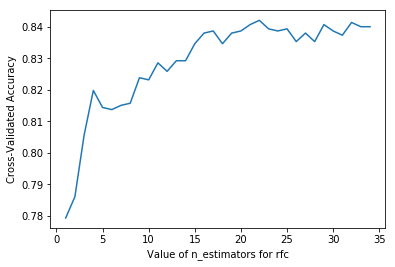

In [13]:
d_range = list(range(1, 35))
d_scores = []
for d in d_range:
    rfc = RandomForestClassifier(n_estimators=d, max_depth=5,random_state=1,n_jobs=-1)
    rfc.fit(x_train, y_train)
    d_scores.append(rfc.score(x_test,y_test))


# plot the value of max_depth for rfc (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(d_range, d_scores)
plt.xlabel('Value of n_estimators for rfc')
plt.ylabel('Cross-Validated Accuracy')

## PCA (with rfc)

Text(0, 0.5, 'Cross-Validated Accuracy')

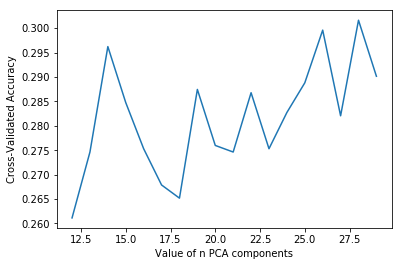

In [14]:
d_range = list(range(12, 30))
d_scores = []
for d in d_range:
    pca = PCA(n_components=d)
    pc = pca.fit_transform(x_train)
    pc_t = pca.fit_transform(x_test)
    rfc = RandomForestClassifier(n_estimators=100, max_depth=20,random_state=1,n_jobs=-1)
    rfc.fit(pc, y_train)
    scores = rfc.score(pc_t,y_test)
    d_scores.append(scores.mean())
plt.plot(d_range, d_scores)
plt.xlabel('Value of n PCA components')
plt.ylabel('Cross-Validated Accuracy')

## Logistic Regression

In [15]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
print(logreg.score(x_test,y_test))

0.835357624831309


In [16]:
y_pred = logreg.predict(x_test)
metrics.confusion_matrix(y_test, y_pred)
df_confusion = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
df_confusion

Predicted,Alone,Spontan,Sync,All
Actual,,,,
Alone,473,0,1,474
Spontan,1,460,45,506
Sync,2,195,305,502
All,476,655,351,1482


In [17]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       Alone       0.99      1.00      1.00       474
     Spontan       0.70      0.91      0.79       506
        Sync       0.87      0.61      0.72       502

   micro avg       0.84      0.84      0.84      1482
   macro avg       0.85      0.84      0.83      1482
weighted avg       0.85      0.84      0.83      1482



In [18]:
lg = LogisticRegression(solver='warn',n_jobs=-1)
lg.fit(x_train, y_train)
print(lg.score(x_test,y_test))

0.835357624831309


Text(0, 0.5, 'Accuracy')

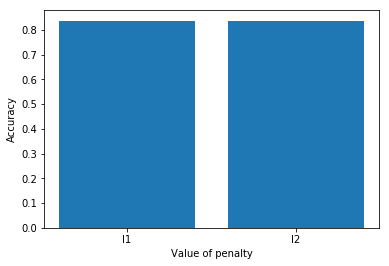

In [19]:
d_range = ['l1', 'l2']
d_scores = []
for d in d_range:
    lg = LogisticRegression(n_jobs=-1, penalty=d)
    lg.fit(x_train, y_train)
    d_scores.append(lg.score(x_test,y_test))
plt.bar(d_range, d_scores)
plt.xlabel('Value of penalty')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Accuracy')

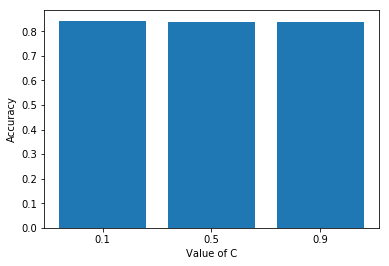

In [20]:
d_range = [0.1,0.5,0.9]
d_scores = []
for d in d_range:
    lg = LogisticRegression(n_jobs=-1, penalty='l1',C=d)
    lg.fit(x_train, y_train)
    d_scores.append(lg.score(x_test,y_test))
drange = ['0.1','0.5','0.9']
plt.bar(drange, d_scores)
plt.xlabel('Value of C')
plt.ylabel('Accuracy')

## Navie bayes

In [21]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(x_train,y_train)
gnb.score(x_test,y_test)

0.8596491228070176

In [22]:
y_pred = gnb.predict(x_test)
metrics.confusion_matrix(y_test, y_pred)
df_confusion = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
df_confusion

Predicted,Alone,Spontan,Sync,All
Actual,,,,
Alone,469,0,5,474
Spontan,3,422,81,506
Sync,8,111,383,502
All,480,533,469,1482


In [23]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       Alone       0.98      0.99      0.98       474
     Spontan       0.79      0.83      0.81       506
        Sync       0.82      0.76      0.79       502

   micro avg       0.86      0.86      0.86      1482
   macro avg       0.86      0.86      0.86      1482
weighted avg       0.86      0.86      0.86      1482



## Experiment with ratio of columns

In [24]:
def recol(x):
    t = x.loc[:, ' Position X':' Pinch Strength']
    tr = x.loc[:, ' Position X r':' Pinch Strength r']
    d = pd.DataFrame(columns=[
        ' Position X',
        ' Position Y',
        ' Position Z',
        ' Velocity X',
        ' Velocity Y',
        ' Velocity Z',
        ' Pitch',
        ' Roll',
        ' Yaw',
        ' Wrist Pos X',
        ' Wrist Pos Y',
        ' Wrist Pos Z',
        ' Elbow pos X',
        ' Elbow Pos Y',
        ' Elbow Pos Z',
        ' Grab Strenth',
        ' Grab Angle',
        ' Pinch Strength',
        ])


    for col in t.columns.values:
        d[col] = abs(t[col] - tr[col + ' r'])
    d = d.join(x['Type'])
    d.replace([np.inf, -np.inf], np.nan, inplace=True)
    d.dropna(inplace=True, axis=0)
    d.reset_index(inplace=True, drop=True)
    return d

trainx_new = recol(train.drop(['Name','Time'], axis = 1))
testx_new = recol(test.drop(['Name','Time'], axis = 1))

In [25]:
gnb = LogisticRegression(n_jobs=-1, penalty='l1',C=0.5)#3% increase
gnb.fit(trainx_new.drop('Type',axis=1),trainx_new['Type'])
print(gnb.score(testx_new.drop('Type',axis=1),testx_new['Type']))
y_pred = gnb.predict(testx_new.drop('Type',axis=1))
print(classification_report(testx_new['Type'], y_pred))

0.888663967611336
              precision    recall  f1-score   support

       Alone       0.98      0.93      0.95       474
     Spontan       0.85      0.88      0.86       506
        Sync       0.85      0.86      0.86       502

   micro avg       0.89      0.89      0.89      1482
   macro avg       0.89      0.89      0.89      1482
weighted avg       0.89      0.89      0.89      1482



##  Ada Boost with and without recol

In [26]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
clf = AdaBoostClassifier(RandomForestClassifier(n_estimators=9, max_depth=2,random_state=1,n_jobs=-1), n_estimators=45, random_state=0)
clf.fit(trainx_new.drop('Type', axis=1), trainx_new['Type'])
clf.score(testx_new.drop('Type', axis=1), testx_new['Type'])

0.8839406207827261

In [27]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
clf = AdaBoostClassifier(RandomForestClassifier(n_estimators=5, max_depth=5,random_state=1,n_jobs=-1), n_estimators=45, random_state=0)
clf.fit(x_train, y_train)
clf.score(x_test, y_test)

0.8792172739541161

In [28]:
from sklearn.decomposition import FastICA
transformer = FastICA(n_components=18)
x_t_train = transformer.fit_transform(x_train)
x_t_test = transformer.fit_transform(x_test)
clf = AdaBoostClassifier(RandomForestClassifier(n_estimators=5, max_depth=5,random_state=1,n_jobs=-1), n_estimators=45, random_state=0)
clf.fit(x_t_train, y_train)
clf.score(x_t_test, y_test)

0.4284750337381916